In [1]:
import pandas as pd
import numpy as np
import re
import catboost
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
gender_sub = pd.read_csv('data/submissions/gender_submission.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
len(train), len(test)

(891, 418)

In [7]:
features = ['PassengerId', 'Pclass', 'Name', 'Sex', 
            'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    train[features], train[['Survived']], test_size=191, random_state=42)

In [9]:
X_train['Survived'] = y_train

In [163]:
X_train['sex_type'] = X_train.Name.apply(lambda x:re.findall(r'\, ([\w ]*)\.', x)[0])
X_val['sex_type'] = X_val.Name.apply(lambda x:re.findall(r'\, ([\w ]*)\.', x)[0])
test['sex_type'] = test.Name.apply(lambda x:re.findall(r'\, ([\w ]*)\.', x)[0])
train['sex_type'] = train.Name.apply(lambda x:re.findall(r'\, ([\w ]*)\.', x)[0])

In [12]:
X_train.Embarked.fillna('none', inplace=True)
X_val.Embarked.fillna('none', inplace=True)

train.Embarked.fillna('none', inplace=True)
test.Embarked.fillna('none', inplace=True)

In [13]:
X_train.Cabin.fillna('none', inplace=True)
X_val.Cabin.fillna('none', inplace=True)
train.Cabin.fillna('none', inplace=True)
test.Cabin.fillna('none', inplace=True)

In [14]:
X_train['noage'] = X_train.Age.isna()
X_val['noage'] = X_val.Age.isna()
test['noage'] = test.Age.isna()
train['noage'] = train.Age.isna()

In [15]:
X_train['newage'] = X_train.Age.fillna(train.Age.mean())
X_val['newage'] = X_val.Age.fillna(train.Age.mean())
test['newage'] = test.Age.fillna(test.Age.mean())
train['newage'] = train.Age.fillna(test.Age.mean())

In [73]:
test['Fare'].fillna(0, inplace=True)
X_train['log_fare'] = X_train['Fare'].apply(lambda x: np.log(1+x))
X_val['log_fare'] = X_val['Fare'].apply(lambda x: np.log(1+x))
test['log_fare'] = test['Fare'].apply(lambda x: np.log(1+x))
train['log_fare'] = train['Fare'].apply(lambda x: np.log(1+x))

In [17]:
X_train['cabin_Z'] = X_train['Cabin'].apply(lambda x: ''.join(list(set(re.findall(r'([A-Za-z]+)', x)))))
X_val['cabin_Z'] = X_val['Cabin'].apply(lambda x: ''.join(list(set(re.findall(r'([A-Za-z]+)', x)))))
test['cabin_Z'] = test['Cabin'].apply(lambda x: ''.join(list(set(re.findall(r'([A-Za-z]+)', x)))))
train['cabin_Z'] = train['Cabin'].apply(lambda x: ''.join(list(set(re.findall(r'([A-Za-z]+)', x)))))

In [21]:
X_train['cabin_count'] = X_train['Cabin'].apply(lambda x: len(re.findall(r'([A-Za-z]+)', x)))
X_val['cabin_count'] = X_val['Cabin'].apply(lambda x: len(re.findall(r'([A-Za-z]+)', x)))
test['cabin_count'] = test['Cabin'].apply(lambda x: len(re.findall(r'([A-Za-z]+)', x)))
train['cabin_count'] = train['Cabin'].apply(lambda x: len(re.findall(r'([A-Za-z]+)', x)))

In [74]:
X_train['cat_log_fare'] = X_train['log_fare'].apply(int)
X_val['cat_log_fare'] = X_val['log_fare'].apply(int)
test['cat_log_fare'] = test['log_fare'].apply(int)
train['cat_log_fare'] = train['log_fare'].apply(int)

In [140]:
X_train['log_age_group'] = X_train.newage.apply(lambda x:int(np.log(x+1)))
X_train['age_group'] = X_train.newage.apply(lambda x: int(x//5))

X_val['log_age_group'] = X_val.newage.apply(lambda x:int(np.log(x+1)))
X_val['age_group'] = X_val.newage.apply(lambda x: int(x//5))

test['log_age_group'] = test.newage.apply(lambda x:int(np.log(x+1)))
test['age_group'] = test.newage.apply(lambda x: int(x//5))

train['log_age_group'] = train.newage.apply(lambda x:int(np.log(x+1)))
train['age_group'] = train.newage.apply(lambda x: int(x//5))

In [139]:
5.0//2

2.0

In [133]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived', 'sex_type', 'noage',
       'newage', 'log_fare', 'cabin_Z', 'cabin_count', 'cat_log_fare',
       'log_age_group', 'age_group'],
      dtype='object')

In [134]:
def explore_feature(f):
    return X_train.groupby(f, as_index=False)\
            .agg({'Survived':np.mean, 'PassengerId': len})\
            .sort_values('Survived', ascending=False, ignore_index=True)

In [135]:
explore_feature(['Sex'])

,Sex,Survived,PassengerId
0,female,0.740741,243
1,male,0.188184,457


In [75]:
explore_feature(['Sex', 'cat_log_fare'])

,Sex,cat_log_fare,Survived,PassengerId
0,female,6,1.000000,1
1,male,6,1.000000,2
2,female,4,0.934783,46
3,female,5,0.875000,16
4,female,3,0.708333,72
5,female,2,0.657407,108
6,male,4,0.380952,42
7,male,3,0.225225,111
8,male,5,0.166667,6
9,male,2,0.146429,280


In [28]:
explore_feature(['Sex', 'Embarked'])

,Sex,Embarked,Survived,PassengerId
0,female,none,1.000000,2
1,female,C,0.884615,52
2,female,Q,0.760000,25
3,female,S,0.689024,164
4,male,C,0.309859,71
5,male,S,0.173789,351
6,male,Q,0.085714,35


In [49]:
explore_feature(['sex_type', 'cabin_Z'])

,sex_type,cabin_Z,Survived,PassengerId
0,Mlle,B,1.000000,1
1,Miss,D,1.000000,3
2,Ms,none,1.000000,1
3,Mrs,F,1.000000,1
4,Mrs,E,1.000000,5
5,Mrs,D,1.000000,6
6,Mrs,B,1.000000,6
7,Mme,B,1.000000,1
8,Mlle,C,1.000000,1
9,Col,A,1.000000,1


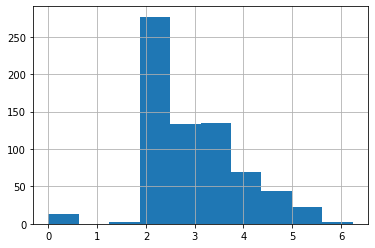

In [58]:
X_train.log_fare.hist()

In [162]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,noage,newage,log_fare,cabin_Z,cabin_count,cat_log_fare,log_age_group,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,none,S,False,22.00000,2.110213,none,1,2,3,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,38.00000,4.280593,C,1,4,3,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,none,S,False,26.00000,2.188856,none,1,2,3,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,35.00000,3.990834,C,1,3,3,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,none,S,False,35.00000,2.202765,none,1,2,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,none,S,False,27.00000,2.639057,none,1,2,3,5
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,False,19.00000,3.433987,B,1,3,2,3
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,none,S,True,30.27259,3.196630,none,1,3,3,6
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,False,26.00000,3.433987,C,1,3,3,5


In [160]:
def train_model(features, cat_features, sub_name=False):
    model = catboost.CatBoostClassifier(verbose=False)
    model.fit(X_train[features], y_train, cat_features=cat_features)
    print(np.mean(model.predict(X_val[features]) == y_val['Survived']))
    print(dict(zip(model.feature_names_, model.feature_importances_)))
    model = catboost.CatBoostClassifier(verbose=False)
    model.fit(train[features], train[['Survived']], cat_features=cat_features)
    print(np.mean(model.predict(train[features]) == train['Survived']))
    if sub_name:
        test['Survived'] = model.predict(test[features])
        test[['PassengerId', 'Survived']].to_csv('data/submissions/' + sub_name, index=False)

In [164]:
use_features = ['Sex', 'sex_type', 'cabin_Z', 
                'Pclass', 'Embarked', 'noage', 'cat_log_fare', 'age_group', 'log_age_group',
                'SibSp', 'Parch', 'newage', 'Fare', 'cabin_count']
cat_features = [0, 1, 2, 3, 4, 5, 6,7,8]
train_model(use_features, cat_features)

0.8167539267015707
{'Sex': 16.675260514113386, 'sex_type': 21.39659121605309, 'cabin_Z': 7.859416702603956, 'Pclass': 14.0985441317203, 'Embarked': 7.063858470736872, 'noage': 0.8629999596874093, 'cat_log_fare': 5.730602251435457, 'age_group': 6.3657759735236805, 'log_age_group': 6.861304192473896, 'SibSp': 2.6507788321499626, 'Parch': 1.8610273503921873, 'newage': 4.3700486509832475, 'Fare': 3.874144223726189, 'cabin_count': 0.3296475304004691}
0.8585858585858586


In [165]:
use_features =  ['Sex', 'sex_type', 'cabin_Z', 
                'Pclass', 'Embarked', 'noage', 'cat_log_fare', 'age_group', 'log_age_group',
                'SibSp', 'Parch', 'newage', 'Fare']
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_model(use_features, cat_features)

0.8167539267015707
{'Sex': 20.266838288883115, 'sex_type': 14.579774046945534, 'cabin_Z': 7.700919725749945, 'Pclass': 14.015532894177035, 'Embarked': 8.411807209979742, 'noage': 0.9063434536175866, 'cat_log_fare': 6.948270282662306, 'age_group': 6.364385787111439, 'log_age_group': 7.017756531707029, 'SibSp': 2.9133554248505105, 'Parch': 1.5353643080977863, 'newage': 5.079887105801488, 'Fare': 4.259764940416469}
0.8574635241301908


In [166]:
use_features =  ['Sex', 'sex_type', 'cabin_Z', 
                'Pclass', 'Embarked', 'noage', 'cat_log_fare', 'age_group', 'log_age_group',
                'SibSp', 'Parch', 'Fare']
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_model(use_features, cat_features)

0.8272251308900523
{'Sex': 15.957991808831066, 'sex_type': 22.230920407123037, 'cabin_Z': 8.299750359678308, 'Pclass': 13.781532553977497, 'Embarked': 7.661184150181776, 'noage': 1.1458026715591727, 'cat_log_fare': 6.215100105300673, 'age_group': 8.005277076780427, 'log_age_group': 7.617166388467769, 'SibSp': 2.8750028412740933, 'Parch': 1.7415833465013306, 'Fare': 4.468688290324851}
0.8507295173961841


In [167]:
use_features =  ['Sex', 'sex_type', 'cabin_Z', 
                'Pclass', 'Embarked', 'noage', 'cat_log_fare', 'age_group', 'log_age_group',
                'SibSp', 'Parch']
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_model(use_features, cat_features, 'last_today.csv')

KeyboardInterrupt: 

In [ ]:
use_features =  ['Sex', 'sex_type', 'cabin_Z', 
                'Pclass', 'Embarked', 'noage', 'cat_log_fare', 'age_group', 'log_age_group',
                'SibSp', 'Parch']
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_model(use_features, cat_features, 'last_today.csv')

0.8272251308900523
{'Sex': 19.02026114981174, 'sex_type': 17.867964369602998, 'cabin_Z': 7.9180447041755615, 'Pclass': 15.232133125871032, 'Embarked': 8.811673052936142, 'cat_log_fare': 8.739428047142516, 'age_group': 8.857673947801725, 'log_age_group': 8.1480115271221, 'SibSp': 3.535291740144283, 'Parch': 1.869518335391803}


In [129]:
explore_feature(['Sex', 'log_age_group'])

,Sex,log_age_group,Survived,PassengerId
0,female,0,1.000000,4
1,female,4,1.000000,11
2,male,0,0.777778,9
3,female,3,0.747191,178
4,female,1,0.642857,14
5,female,2,0.638889,36
6,male,1,0.615385,13
7,male,3,0.169492,354
8,male,4,0.142857,28
9,male,2,0.132075,53


In [131]:
explore_feature(['Sex', 'age_group'])

,Sex,age_group,Survived,PassengerId
0,male,16.0,1.000000,1
1,female,12.0,1.000000,3
2,female,11.0,1.000000,5
3,female,7.0,0.900000,20
4,female,10.0,0.888889,9
5,female,6.0,0.880000,25
6,female,8.0,0.769231,13
7,female,3.0,0.750000,24
8,female,4.0,0.743590,39
9,female,9.0,0.727273,11
